# RSNA Pneumonia Detection Challenge

for more detail, please visit:
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

**Goal:**: Help to detect pneumonia via chest radiograph (CXR), improve the efficiency and reach of diagnostic services

**Model Evaluation:**

Looking at the mean average precision by:

1. *Intersection over Union(IoU)*:    
    predicted $\bigcap$ true area $\div$ predict $\bigcup$ true area
       -IoU will have range from 0~1, but they only evaluate from 0.4 to 0.75 with step of 0.05, and it will function as a threshold, t.
2. *Precision Value (PV)*: PV(t)=$\frac{TP(t)}{TP(t)+FP(t)+FN(t)}$

The average precision of a single image

=$\frac{1}{thresholds}\sum_{i=1}^{t}{\frac{TP(t)}{TP(t)+FP(t)+FN(t)}}$

**The given csv files:**

1.stage_1_train_labels.csv:

    the training set. Contains patientIds and bounding box / target information

2.stage_1_sample_submission.csv: 

    a sample submission file in the correct format.

3.stage_1_detailed_class_info.csv:

    provides detailed information about the type of positive or negative class for each image.

**The given image files:**

1.stage_1_test_images (1000 images)

2.stage_1_train_images (25684 images)

all in DICOM format 

# Data exploration

In [21]:
import glob
import pydicom as dcm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
IS_LOCAL = False
if(IS_LOCAL):
    PATH="data/rsna-pneumonia-detection-challenge"
else:
    PATH="data"
print(os.listdir(PATH))

%matplotlib inline
# np.warnings.filterwarnings('ignore')

['GCP Credits Request Link - RSNA.txt', 'stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_test_images', 'stage_1_train_images', 'stage_1_train_labels.csv']


### Read csv files:

In [2]:
labels = pd.read_csv('data/stage_1_train_labels.csv')
details = pd.read_csv('data/stage_1_detailed_class_info.csv')
# duplicates in details just have the same class so can be safely dropped
details = details.drop_duplicates('patientId').reset_index(drop=True)
labels_w_class = labels.merge(details, how='inner', on='patientId')

In [3]:
labels_w_class.describe()

,x,y,width,height,Target
count,8964.000000,8964.000000,8964.000000,8964.000000,28989.000000
mean,391.456158,363.135877,220.845382,334.174364,0.309221
std,203.945378,148.607149,59.041384,158.097239,0.462180
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,205.000000,246.000000,180.000000,207.000000,0.000000
50%,320.000000,360.000000,219.000000,304.000000,0.000000
75%,591.000000,475.000000,261.000000,445.000000,1.000000
max,817.000000,881.000000,528.000000,942.000000,1.000000


### Read description part of the image files

In [8]:
# get lists of all train/test dicom filepaths
train_dcm_fps = glob.glob('data/stage_1_train_images/*.dcm')
test_dcm_fps = glob.glob('data/stage_1_test_images/*.dcm')

# read each file into a list (using stop_before_pixels to avoid reading the image for speed and memory savings)
train_dcms = [dcm.read_file(x, stop_before_pixels=True) for x in train_dcm_fps]
test_dcms = [dcm.read_file(x, stop_before_pixels=True) for x in test_dcm_fps]

In [11]:
train_dcms[1]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.26024.1517874469.23011
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '00313ee0-9eaa-42f4-b0ab-c148ed3241cd'
(0010, 0020) Patient ID                          LO: '00313ee0-9eaa-42f4-b0ab-c148ed3241cd'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

### Plot DICOM images with Target = 1

In [12]:
def show_dicom_images(data):
    img_data = list(data[:9].T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_1_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

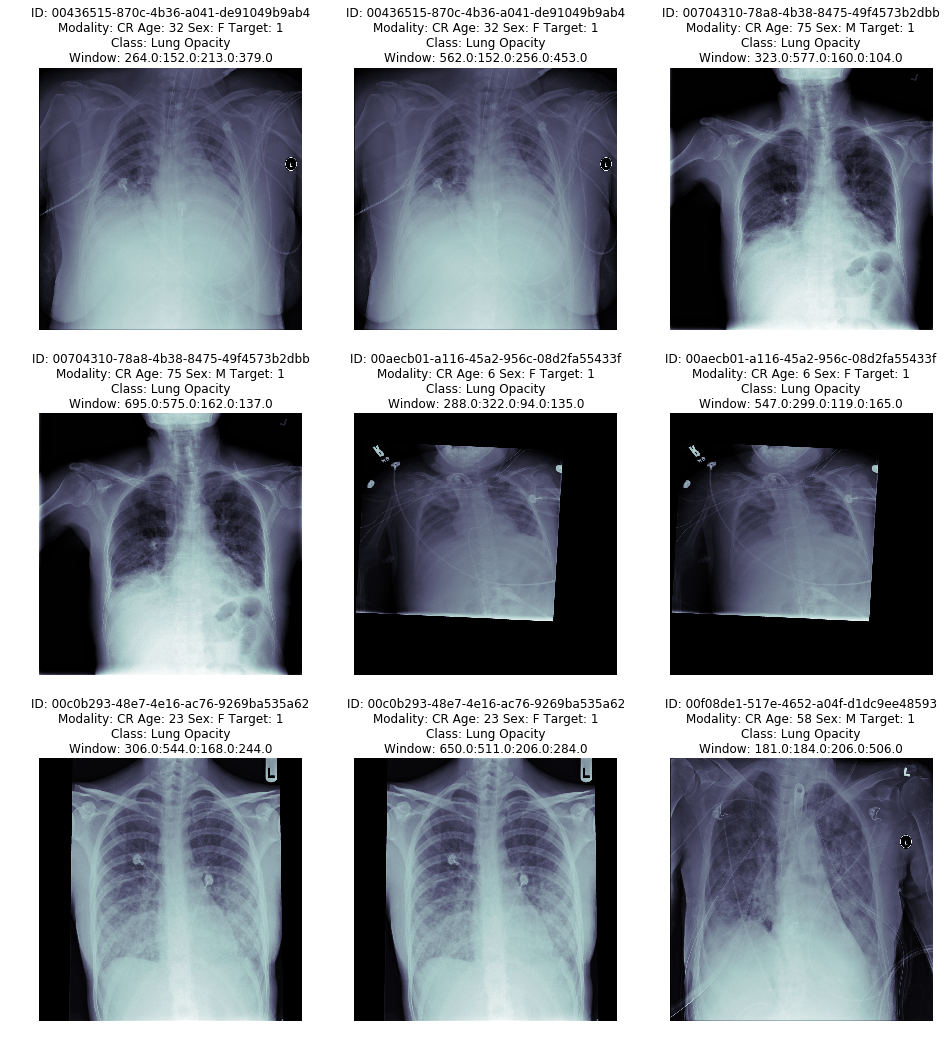

In [22]:
show_dicom_images(labels_w_class[labels_w_class['Target']==1])